# Домашнее задание 2. Преобразование данных

Цель этого задания -- преобразовать имеющиеся атрибуты пользователей в признаки так, чтобы полученная матрица признаков была пригодна для подачи в алгоритм кластеризации. Этап конструирования признаков -- самый важный и обычно самый долгий. К нему возвращаются много раз на протяжении решения задачи анализа данных.

Кроме библиотек, использованных в первом задании, нам понадобятся следующие библиотеки:
1. [scikit-learn](http://scikit-learn.org/stable/) -- библиотека, реализующая множество алгоритмов машинного обучения и сопутствующих алгоритмов

In [22]:
import pandas as pd
import numpy as np
import pylab as pl
import sklearn.preprocessing as sp
import csv
import re
import dateutil

np.set_printoptions(linewidth=150, precision=3, suppress=True)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
ts_parser = lambda date_str: datetime.datetime.strptime(date_str, "%Y-%m") if pd.notnull(date_str) and date_str else None
df_users = pd.read_csv("hw1_out.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC, converters={"created_at": ts_parser})
# Remove rows with users not found
df_users = df_users[pd.notnull(df_users['name'])]
df_users["lat"].fillna(value=0, inplace=True)
df_users["lon"].fillna(value=0, inplace=True)

Далее необходимо ввести новые признаки. Для каждого пользователя предлагается ввести следующие признаки:
- name_words - количество слов в имени
- screen_name_length - количество символов в псевдониме
- description_length - длина описания
- created_year - год создания аккаунта
- country_code - код страны
- verified - предлагается перевести в тип int

In [24]:
def isNaN(num):
    return num != num

def create_new_features(df_users, features):
    # Introduce new features
    new_features = ["name_words", "screen_name_length", "description_length", "created_year", "country_code", "verified"]

    country_set = set()
    for index, user in df_users.iterrows():
        country_set.add(user["country"])

    country_codes = {}
    code = 0
    for country in country_set:
        country_codes[country] = code
        code += 1

    feature_calculators = {
        "name_words": lambda record: len(re.split('[;:., ]+', unicode(record["name"]))),
        "screen_name_length": lambda record: len(unicode(record["screen_name"])),
        "description_length": lambda record: 0 if isNaN(record["description"]) else len(unicode(record["description"])),
        "created_year": lambda record: record["created_at"].year,
        "country_code": lambda record: country_codes[record["country"]],
        "verified": lambda record: 1 if record["verified"] else 0
    }

    for feature in feature_calculators:

        feature_data = []
        for index, user in df_users.iterrows():
            feature_data.append(feature_calculators[feature](user))

        df_users[feature] = feature_data

    all_features = []
    for feature_i in df_users.columns.values:
        if feature_i in features + new_features:
            all_features.append(feature_i)
    return df_users, all_features

In [25]:
features = ["lat", "lon", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
df_users, features = create_new_features(df_users, features)

x = df_users[pd.notnull(df_users.cat)][features].values
y = df_users[pd.notnull(df_users.cat)]["cat"].values

Посмотрим, являются ли какие-либо из выбранных признаков сильно скоррелированными. Для этого посчитаем матрицу корреляций и выберем те пары признаков, фбсолютное значения коэффициента корреляции между которыми больше 0.2. Необходимо реализовать функцию find_correlated_features, в которой нужно рассчитать коэффициенты корелляции и вывести те, которые больше 0.2. Подсказка: предлагается найти необходимую функцию в библиотеке np и реализовать find_correlated_features с использованием не более 5 строк кода.

In [26]:
def find_correlated_features(x, features):
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            if i < j:
                coeff = np.corrcoef(x[i], x[j])[0][1]
                if abs(coeff) >= 0.2:
                    print "Correlated features: %s + %s -> %.2f" % (feature_i, feature_j, coeff)
    

In [11]:
find_correlated_features(x, features)

Correlated features: lat + lon -> 0.51
Correlated features: lat + followers_count -> 0.51
Correlated features: lat + friends_count -> 0.51
Correlated features: lat + statuses_count -> 0.51
Correlated features: lat + favourites_count -> 0.51
Correlated features: lat + listed_count -> 0.51
Correlated features: lon + followers_count -> 0.51
Correlated features: lon + friends_count -> 0.51
Correlated features: lon + statuses_count -> 0.51
Correlated features: lon + favourites_count -> 0.51
Correlated features: lon + listed_count -> 0.51
Correlated features: followers_count + friends_count -> 0.51
Correlated features: followers_count + statuses_count -> 0.51
Correlated features: followers_count + favourites_count -> 0.51
Correlated features: followers_count + listed_count -> 0.51
Correlated features: friends_count + statuses_count -> 0.51
Correlated features: friends_count + favourites_count -> 0.51
Correlated features: friends_count + listed_count -> 0.51
Correlated features: statuses_coun

Выделилось 3 группы признаков:
1. Основанные на географии:  "lat", "lon", "country_code"
2. Основанные на социальной активности:  "verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"
3. Остальные:  "name_words", "screen_name_length", "description_length"

Построим взаимные распределения пар признаков в каждой из групп, а также гистограмму значений каждого из признаков с учетом целевой переменной.

In [27]:
def plot_two_features_scatter(x_i, x_j, y, colors):
    pl.scatter(x_j, x_i, c=colors, linewidths=0)

def plot_feature_histogram(x_i, y, colors):

    positive = []
    negative = []
    for i, cl in enumerate(y):
        if cl == 0:
            positive.append(x_i[i])
        else:
            negative.append(x_i[i])


    pl.hist((negative, positive), bins=20, color=("g", "r"))

def plot_dataset(x, y, features):
    # Tune your plot if necessary
    # your code here
    colors = []
    for cl in y:
        if cl == 0:
            colors.append('r')
        else:
            colors.append('g')

    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):

            size = (len(features), len(features))
            plot = pl.subplot2grid(size, (i, j))
            plot.set_xticklabels([])
            plot.set_yticklabels([])
            plot.xaxis.set_label_position("top")
            if i != j:
                plot_two_features_scatter(x[:, i], x[:, j], y, colors)
            else:
                plot_feature_histogram(x[:, i], y, colors)

            if i == 0:
                pl.xlabel(feature_j)

            if j == 0:
                pl.ylabel(feature_i)

    pl.show()

Построим попарные распределения географических признаков ([подсказка](http://anokhin.github.io/img/hw2_geo.png)).

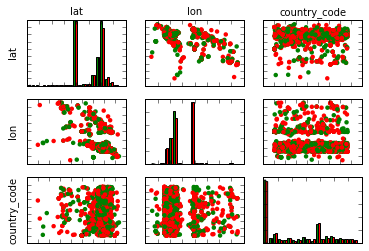

In [9]:
geo_features_new = ["lat", "lon", "country_code"]
geo_features = [f for f in geo_features_new if f in features]

geo_feature_ind = [i for i, f in enumerate(features) if f in geo_features]
plot_dataset(x[:, geo_feature_ind], y, geo_features)

Четко видны очертания карты и то, что большинство пользователей происходят из небольшого набора стран. Если принять во внимание конечную цель -- кластеризацию пользователей -- логично предположить, что использование географических признаков для описания пользователя может оказаться не очень полезным. Причина в том, что эти признаки четко пространственно разделены (как минимум, океанами и морями). Поэтому мы рискуем вместо "интересной" кластеризации получить просто кластеры, которые будут представлять разные страны. В дальнейшем мы исключим географические признаки из рассмотрения при кластеризации пользователей.

Далее построим попарные распределения социальных признаков ([подсказка](http://anokhin.github.io/img/hw2_social1.png)).

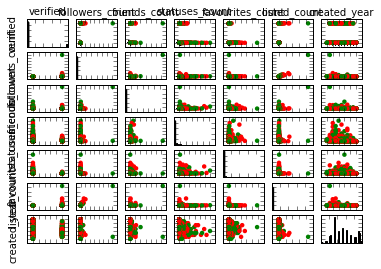

In [28]:
social_features_new = ["verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"]
social_features = [f for f in social_features_new if f in features]
social_feature_ind = [i for i, f in enumerate(features) if f in social_features]
plot_dataset(x[:, social_feature_ind], y, social_features)

Из графиков видно, что признаки "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count" сильно смещены в сторону небольших значений. В таком случае удобно сделать логарифмическое преобразрвание этих признаков, то есть применить к их значениям $x_{ij}$ функцию $\log(1 + x_{ij})$. Сделаем это и построим новые распределения ([подсказка](http://anokhin.github.io/img/hw2_social2.png)). Необходимо реализовать функцию log_transform_features, которая выполняет указанное логарифмическое преобразование.

Correlated features: verified + lat -> 0.96
Correlated features: verified + followers_count -> 0.97
Correlated features: verified + friends_count -> 0.99
Correlated features: verified + statuses_count -> 1.00
Correlated features: verified + favourites_count -> 0.40
Correlated features: verified + screen_name_length -> 0.23
Correlated features: verified + name_words -> 0.97
Correlated features: lat + followers_count -> 1.00
Correlated features: lat + friends_count -> 0.94
Correlated features: lat + statuses_count -> 0.95
Correlated features: lat + favourites_count -> 0.61
Correlated features: lat + listed_count -> 0.32
Correlated features: lat + screen_name_length -> 0.39
Correlated features: lat + created_year -> 0.23
Correlated features: lat + name_words -> 0.91
Correlated features: lat + country_code -> 0.28
Correlated features: lat + description_length -> 0.20
Correlated features: lon + screen_name_length -> 0.76
Correlated features: lon + description_length -> 0.77
Correlated featu

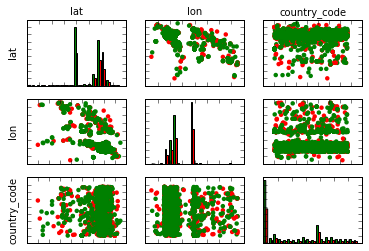

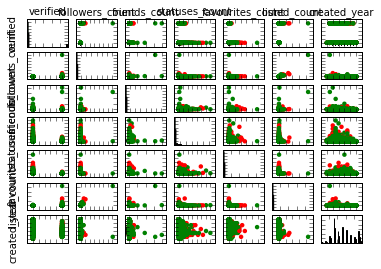

In [32]:
def log_transform_features(data, features, transformed_features):
    for i, user in enumerate(data):
        for feature in transformed_features:
            if feature in features:
                j = features.index(feature)
                user[j] = np.log(1 + user[j])
    return data
np.set_printoptions(linewidth=150, precision=3, suppress=True)
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None
df_users = pd.read_csv("hw1_out.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC, converters={"created_at": ts_parser})
# Remove rows with users not found
df_users = df_users[pd.notnull(df_users['name'])]
df_users["lat"].fillna(value=0, inplace=True)
df_users["lon"].fillna(value=0, inplace=True)

features = ["lat", "lon", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
df_users, features = create_new_features(df_users, features)

x = df_users[features].values
y = df_users["cat"].values

find_correlated_features(x, features)

geo_features_new = ["lat", "lon", "country_code"]
geo_features = [f for f in geo_features_new if f in features]
geo_feature_ind = [i for i, f in enumerate(features) if f in geo_features]
plot_dataset(x[:, geo_feature_ind], y, geo_features)

social_features_new = ["verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"]
social_features = [f for f in social_features_new if f in features]
social_feature_ind = [i for i, f in enumerate(features) if f in social_features_new]
plot_dataset(x[:, social_feature_ind], y, social_features)



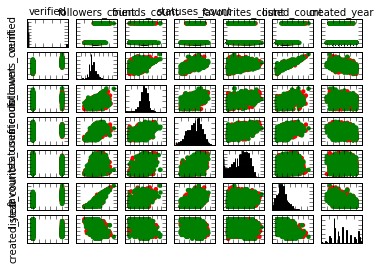

In [33]:
transformed_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
x = log_transform_features(x, features, transformed_features)

# Re-plot features
plot_dataset(x[:, social_feature_ind], y, social_features)

Сразу бросается в глаза, что признак "verified" сильно смещен -- верифицированных пользователей очень мало. Более того, все верифицированные пользователи имеют много фолловеров, поэтому часть информации о верификации дублируется в признаке "followers_count". По этой причине в дальнейшем не будем рассмтаривать признак "verified".

После того как мы с помощью логарифмического преобразования избавились от сильной скошенности признаков, можно наблюдать некоторые интересные зависимости. Например, пользователи, имеющие много фолловеров, обязательно имеют много статусов. Следовательно, чтобы стать популярным, обязательно нужно много писать. Анализ других зависимостей остается как упражнение.

Наконец построим попарные распределения остальных признаков ([подсказка](http://anokhin.github.io/img/hw2_other.png)).

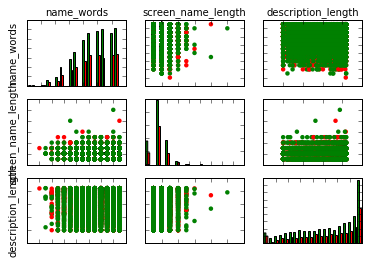

In [34]:
other_features_new = ["name_words", "screen_name_length", "description_length"]
other_features = [f for f in other_features_new if f in features]
other_feature_ind = [i for i, f in enumerate(features) if f in other_features]
plot_dataset(x[:, other_feature_ind], y, other_features)

Итак после первичной обработки данных мы имеем 9 числовых признаков, каждый из которых распределен в некотором своем интервале. Для того, чтобы ни один признак не получил перевеса при кластеризации, нормализуем данные так, что каждый признак распределен на отрезке $[0, 1]$. 

In [35]:
selected_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", 
                     "listed_count", "created_year", "name_words", "screen_name_length", "description_length"]

x_1 = df_users[selected_features].values
y = df_users["cat"].values

# x_1 = x[:, selected_features_ind]
# Replace nan with 0-s
# Is there a smarter way?
x_1[np.isnan(x_1)] = 0
x_min = x_1.min(axis=0)
x_max = x_1.max(axis=0)
x_new = (x_1 - x_min) / (x_max - x_min)

Упакуем полученную матрицу в pandas DataFrame и сохраним в файл "hw2_out.csv". В следующем задании мы будем кластеризовать пользователей на оновании этих данных.

In [36]:
df_out = pd.DataFrame(data=x_new, index=df_users["uid"], columns=[f for f in selected_features])
df_out.to_csv("hw2_out.csv", sep="\t")